<a href="https://colab.research.google.com/github/GTRe5/AI/blob/main/Task1_8PUZZLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise: Visualizing the state space of 8-puzzle game

## Introduction to graphviz

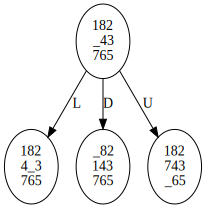

In [ ]:
from graphviz import Digraph
import numpy as np

dot = Digraph()
dot.node('0', '182\n_43\n765')
dot.node('1', '182\n4_3\n765')
dot.node('2', '_82\n143\n765')
dot.node('3', '182\n743\n_65')
dot.edge('0', '1', 'L')
dot.edge('0', '2', 'D')
dot.edge('0', '3', 'U')

dot

## Defining Node class


In [ ]:
# Import library
from copy import deepcopy
from graphviz import Digraph
import heapq
import random
import time
import numpy as np
import IPython.display as IPd

In [ ]:
class Node:
  def __init__(self, state, action=None, parent=None, path_cost=0):
    self.state = state  # 2D list (3x3)
    self.id = str(self)  # identifier of node
    self.action = action
    self.parent = parent
    self.path_cost = path_cost  # g(n) in A*

  def __str__(self):
    '''
    Return a string representing the state of the node.
    Note to remember the 0 digit by '_'
    e.g., '182\n_43\n765'
    '''
    result = ""
    for i in range(3):
      for j in range(3):
        if self.state[i][j] == 0:
          result += '_'
        else:
          result += str(self.state[i][j])
      result += '\n'
    return result.strip() # "\n".join("".join(str(cell) if cell != 0 else '_' for cell in row) for row in self.state)

  def __lt__(self, other):
    # Required for priority queue comparison
    return self.path_cost < other.path_cost

  def get_successors(self):
    '''
    Return the list of successors of the state (self).
    '''
    successors = list()
    for action in ['L', 'R', 'U', 'D']:
      successor = self.get_successor(action, deepcopy(self.state))
      if successor is not None:
        successors.append(Node(successor, action, self))

    return successors

  def get_successor(self, action, state):
    pi, pj = self.get_blank_pos(state)  # Get the blank tile position
    new_pi, new_pj = self.get_dest_pos(action, pi, pj)  # Compute new position

    if 0 <= new_pi < 3 and 0 <= new_pj < 3:
      # Swap blank with the target tile
      state[pi][pj], state[new_pi][new_pj] = state[new_pi][new_pj], state[pi][pj]

      # Special Rule: Swap (1 <-> 3) and (2 <-> 4) if they are adjacent **after** the blank move
      swap_pairs = {(1, 3), (3, 1), (2, 4), (4, 2)}

      # Check horizontally adjacent values
      for i in range(3):
        for j in range(2):
          if (state[i][j], state[i][j+1]) in swap_pairs:
            state[i][j], state[i][j+1] = state[i][j+1], state[i][j]

      # Check vertically adjacent values
      for i in range(2):
        for j in range(3):
          if (state[i][j], state[i+1][j]) in swap_pairs:
            state[i][j], state[i+1][j] = state[i+1][j], state[i][j]

      return state  # Return the updated state
    return None  # Return None if the move is invalid

  def get_dest_pos(self, action, pi, pj):
    if action == 'L':
      pj += 1
    if action == 'R':
      pj -= 1
    if action == 'U':
      pi += 1
    if action == 'D':
      pi -= 1
    return pi, pj

  def get_blank_pos(self, state):
    '''
    Return the location (i, j) of the 0 digit (blank cell).
    '''
    for i in range(3):
      for j in range(3):
        if state[i][j] == 0:
          return i, j
    return None, None # next((i, j) for i in range(3) for j in range(3) if state[i][j] == 0)

  def get_id(self):
    return self.id

  def get_node_str(self):
    return str(self)

  def get_action(self):
    return self.action

  def draw(self, dot):
    dot.node(self.get_id(), self.get_node_str())
    if self.parent is not None:
      dot.edge(self.parent.get_id(), self.get_id(), self.get_action())


## Goal states

In [ ]:
GOAL_STATES = [
    [[1, 2, 3], [4, 5, 6], [7, 8, 0]],  # Goal state 1
    [[8, 7, 6], [5, 4, 3], [2, 1, 0]],  # Goal state 2
    [[0, 1, 2], [3, 4, 5], [6, 7, 8]],  # Goal state 3
    [[8, 7, 0], [6, 5, 4], [3, 2, 1]]   # Goal state 4
]

def is_goal(state):
    """Check if the current state is one of the goal states"""
    return any(state == goal for goal in GOAL_STATES)

In [ ]:
def get_min_heuristic(state, heuristic_func):
    """
    Calculate the minimum heuristic value across all goal states.
    This ensures our heuristic is admissible for multiple goal states.
    """
    min_h = float('inf')
    for goal in GOAL_STATES:
        h = heuristic_func(state, goal)
        if h < min_h:
            min_h = h
    return min_h

## Implement 2 heuristic functions **h(n)** and **A* search**

### 1. Manhattan distance - a.k.a admissible and consistent

In [ ]:
def manhattan_distance(state, goal_state):
  """
  For each tile (except the blank), calculate the distance from its current
  position to its position in the goal state, then sum all distances.
  """
  distance = 0
  for i in range(3):
    for j in range(3):
      if state[i][j] != 0:  # Skip the blank tile
        for gi in range(3):
          for gj in range(3):
            if goal_state[gi][gj] == state[i][j]:
              distance += abs(i - gi) + abs(j - gj)
              break
  return distance

### 2. Misplaced tiles - a.k.a admissible

In [ ]:
def misplaced_tiles(state, goal_state):
  """
  Calculate the number of misplaced tiles (excluding the blank).
  This is the number of tiles that are not in their correct position.
  """
  count = 0
  for i in range(3):
    for j in range(3):
      if state[i][j] != 0 and state[i][j] != goal_state[i][j]:
        count += 1
  return count

### 3. A* search

In [ ]:
def a_star_search(initial_state, heuristic_func, max_nodes=10000):
  """
  A* search algorithm for the 8-puzzle.

  Args:
    initial_state: The initial state of the puzzle
    heuristic_func: The heuristic function to use (manhattan_distance or misplaced_tiles)
    max_nodes: Maximum number of nodes to expand

  Returns:
    A tuple of (solution_node, nodes_expanded, visited_nodes)
  """
  start_node = Node(initial_state)

  #Priority queue for frontier (f=g+h)
  frontier = []
  frontier_dict = {}

  #Use the node ID (string representation) for the closed set
  closed_set = set()

  #The f(n) value is the sum of g(n) (path cost) and h(n) (heuristic)
  h_value = get_min_heuristic(start_node.state, heuristic_func)
  f_value = start_node.path_cost + h_value

  #Push (f_value, node) to the priority queue
  entry_count = 0
  heapq.heappush(frontier, (f_value, entry_count, start_node))
  frontier_dict[start_node.id] = (f_value, start_node.path_cost)
  entry_count += 1

  nodes_expanded = 0
  visited_nodes = [start_node]  #For visualization

  while frontier and nodes_expanded < max_nodes:
    #Pop the node with lowest f-value
    _,_, current_node = heapq.heappop(frontier)

    #Skip if already processed
    if current_node.id not in frontier_dict:
      continue

    #Remove from frontier dictionary
    del frontier_dict[current_node.id]

    #Skip if already in closed set
    if current_node.id in closed_set:
      continue

    #Check if we've reached the goal then construct goal path
    if is_goal(current_node.state):
      path = []
      while current_node:
        path.append(current_node)
        current_node = current_node.parent
      return path[::-1], nodes_expanded, visited_nodes

    #Add to closed set
    closed_set.add(current_node.id)
    nodes_expanded += 1

    #Generate successors
    for successor in current_node.get_successors():
      successor.path_cost = current_node.path_cost + 1
      successor_h = get_min_heuristic(successor.state, heuristic_func)
      successor_f = successor.path_cost + successor_h

      if successor.id in closed_set:
        continue

      #Check if in frontier with higher cost
      if successor.id in frontier_dict:
        old_f, old_g = frontier_dict[successor.id]

        if successor.path_cost < old_g:
          frontier_dict[successor.id] = (successor_f, successor.path_cost)
          heapq.heappush(frontier, (successor_f, entry_count, successor))
          entry_count += 1
          visited_nodes.append(successor)
      else:
        #New state, add to frontier
        heapq.heappush(frontier, (successor_f, entry_count, successor))
        frontier_dict[successor.id] = (successor_f, successor.path_cost)
        entry_count += 1
        visited_nodes.append(successor)

  #If we get here, we failed to find a solution
  return None, nodes_expanded, visited_nodes

In [ ]:
# Function to visualize the search tree
def draw_tree(visited_nodes, max_display=100, solution_path_only=False):
    """
    draw the search tree.

    Args:
        visited_nodes: List of nodes visited during search
        max_display: Maximum number of nodes to display (default: 100)
        solution_path_only: If True, only show the solution path (default: False)
    """
    dot = Digraph()
    #Only show solution path
    if solution_path_only and visited_nodes:

        solution_node = visited_nodes[-1]
        path_nodes = []
        current = solution_node

        while current:
            path_nodes.append(current)
            current = current.parent
        path_nodes.reverse()

        for node in path_nodes:
            node.draw(dot)
    else:
        nodes_to_show = visited_nodes[:max_display] if len(visited_nodes) > max_display else visited_nodes

        for node in nodes_to_show:
            node.draw(dot)

        if len(visited_nodes) > max_display:
            dot.attr(label=f"\nShowing {max_display} of {len(visited_nodes)} nodes")



    return dot

In [ ]:
def save_and_display_search_graphs(visited_nodes, path, nodes_expanded, display_images=True, path_only=True, max_display=100):
    """
    Visualizes and saves both full search graph and solution path graphs as PNG files.

    Parameters:
    -----------
    visited_nodes : list or set
        The nodes visited during the search
    path : list
        The solution path found by the search algorithm
    nodes_expanded : int
        Maximum number of nodes to display in the full graph
    display_images : bool, optional (default=True)
        Whether to display the saved images after saving
    path_only : bool, optional (default = True)
        Whether to display only path images

    Returns:
    --------
    tuple
        (full_graph, solution_graph) visualization objects
    """
    # Create the full search graph visualization
    full_graph = draw_tree(visited_nodes,
                      max_display=max_display,
                      solution_path_only=False)

    # Create the solution path visualization
    solution_graph = draw_tree(path,
                          max_display=max_display,
                          solution_path_only=True)

    # Save files as PNG
    solution_graph.render('solution_path', format='png', cleanup=True)
    full_graph.render('full_graph', format='png', cleanup=True)

    # Display images if requested
    if display_images:
      if path_only:
        path_img = IPd.Image('solution_path.png')
        IPd.display(path_img)
      else:
        full_img = IPd.Image('full_graph.png')
        IPd.display(full_img)

    return full_graph, solution_graph

In [ ]:
def generate_random_puzzle(max_steps = 100):
    """Generates a random solvable 8-puzzle state."""
    # Start with the first goal state
    state = deepcopy(GOAL_STATES[0])
    node = Node(state)

    for _ in range(max_steps):
        successors = node.get_successors()
        if successors:
            node = random.choice(successors)

    return node.state

#print(generate_random_puzzle())

In [ ]:
def solve_8puzzle():
    heuristic_choice = input("Choose heuristic (1: Manhattan Distance, 2: Misplaced Tiles): ").strip()

    if heuristic_choice == "1":
        heuristic_func = manhattan_distance
        print("Using Manhattan Distance heuristic.")
    elif heuristic_choice == "2":
        heuristic_func = misplaced_tiles
        print("Using Misplaced Tiles heuristic.")
    else:
        print("Invalid choice! Defaulting to Manhattan Distance.")
        heuristic_func = manhattan_distance

    initial_state = generate_random_puzzle()

    try:
        # First attempt with 1000 nodes
      solution_path, nodes_expanded, visited_nodes = a_star_search(initial_state, heuristic_func, max_nodes=1000)
      if not solution_path:
        raise RuntimeError("Not enough nodes expanded, increasing limit...")  # Force retry with more nodes
    except RuntimeError:
      print("Expanding search to 5000 nodes...")
      solution_path, nodes_expanded, visited_nodes = a_star_search(initial_state, heuristic_func, max_nodes=5000)

    print(f"Nodes expanded: {nodes_expanded}")
    if solution_path:
        print("Solution found!")
        return solution_path, nodes_expanded, visited_nodes
    else:
        print("No solution found.")
        return None, nodes_expanded, visited_nodes

Choose heuristic (1: Manhattan Distance, 2: Misplaced Tiles): 1
Using Manhattan Distance heuristic.
Nodes expanded: 445
Solution found!
Do you want to display the search graph images? (yes/no): yes
Do you want to display only the solution path? (yes/no): no
Enter the maximum number of nodes to display (e.g., 100): 500
Saving and displaying graphs...


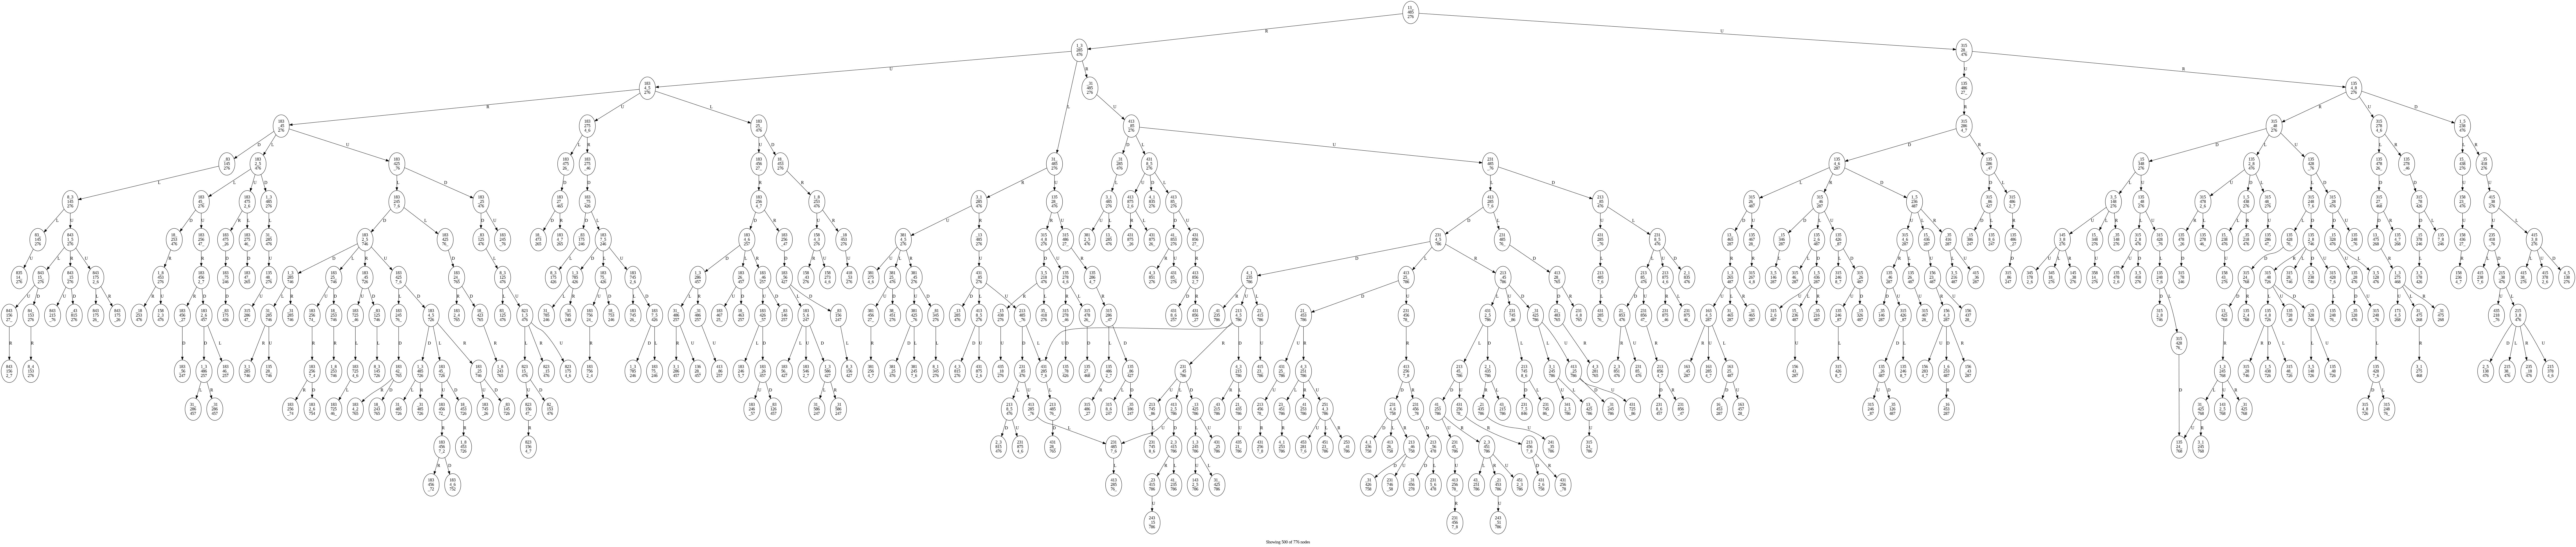

In [ ]:
solution_path, nodes_expanded, visited_nodes = solve_8puzzle()
if solution_path:
  show_images = input("Do you want to display the search graph images? (yes/no): ").strip().lower()
  path_only = input("Do you want to display only the solution path? (yes/no): ").strip().lower()
  max_display = input("Enter the maximum number of nodes to display (e.g., 100): ").strip()

  # Convert inputs
  display_images = show_images == "yes"
  path_only = path_only == "yes"


  try:
    max_display = int(max_display)
    if max_display < 1:
        print("Can't display negative or zero nodes! Defaulting to 100.")
        max_display = 100  # Default value
  except ValueError:
    print("Invalid input for max_display. Defaulting to 100.")
    max_display = 100

  print("Saving and displaying graphs...")  # Debugging print

  save_and_display_search_graphs(visited_nodes, solution_path, nodes_expanded,
                                 display_images=display_images,
                                 path_only=path_only,
                                 max_display=max_display)